In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

os.makedirs("outputs_CV", exist_ok=True)

In [2]:
df = pd.read_csv("../data/StudentsPerformance.csv")

# Add average and result columns.
df["average"] = df[["math score", "reading score", "writing score"]].mean(axis=1)
df["result"] = df["average"].apply(lambda x: "geçti" if x >= 40 else "kaldı")

# Quantify categorical variables.
label_cols = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Features and target
X = df.drop(["average", "result"], axis=1)
y = LabelEncoder().fit_transform(df["result"])  # Passed=1, Failed=0

In [3]:
# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=13),
    "DT": DecisionTreeClassifier(),
    "NB": GaussianNB(),
    "RF": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel="rbf", C=2, probability=True),
    "LR": LogisticRegression(max_iter=250),
    "LDA": LinearDiscriminantAnalysis()
}

In [4]:
def compute_metrics(Xdata, label):
    out = []
    for name, model in models.items():
        acc = cross_val_score(model, Xdata, y, cv=cv, scoring="accuracy").mean()
        prec = cross_val_score(model, Xdata, y, cv=cv, scoring="precision").mean()
        rec  = cross_val_score(model, Xdata, y, cv=cv, scoring="recall").mean()
        f1   = cross_val_score(model, Xdata, y, cv=cv, scoring="f1").mean()
        out.append({"Model": name, "Metric": "Accuracy",  label: acc})
        out.append({"Model": name, "Metric": "Precision", label: prec})
        out.append({"Model": name, "Metric": "Recall",    label: rec})
        out.append({"Model": name, "Metric": "F1",        label: f1})
    return pd.DataFrame(out)

In [5]:
# Normalization
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Metric tables
before_df = compute_metrics(X, "Before")
after_df  = compute_metrics(X_scaled, "After")

# Comparison table with pivot
comp = (before_df.merge(after_df, on=["Model","Metric"])
            .pivot(index="Model", columns="Metric", values=["Before","After"]))

<Figure size 900x400 with 0 Axes>

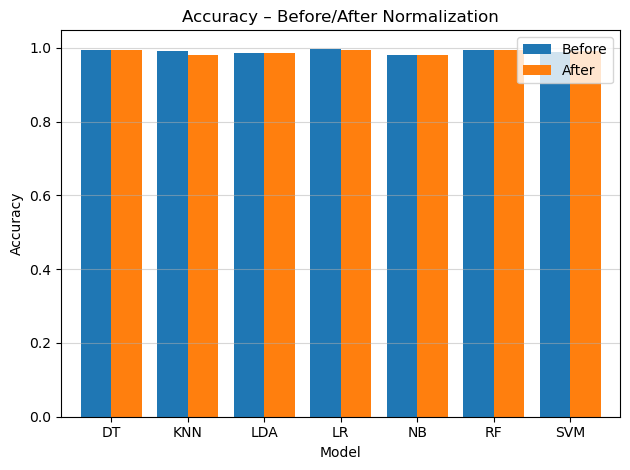

<Figure size 900x400 with 0 Axes>

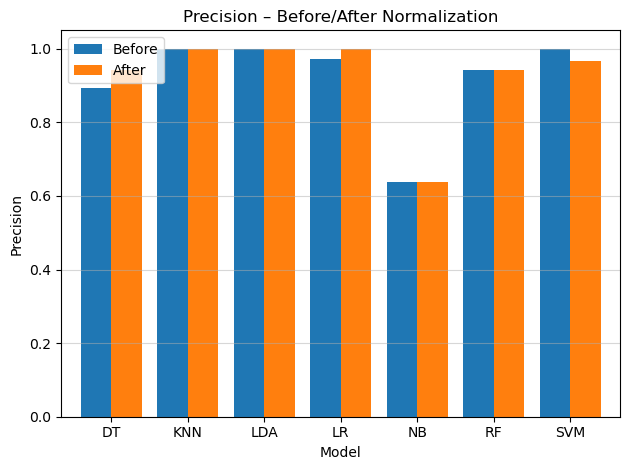

<Figure size 900x400 with 0 Axes>

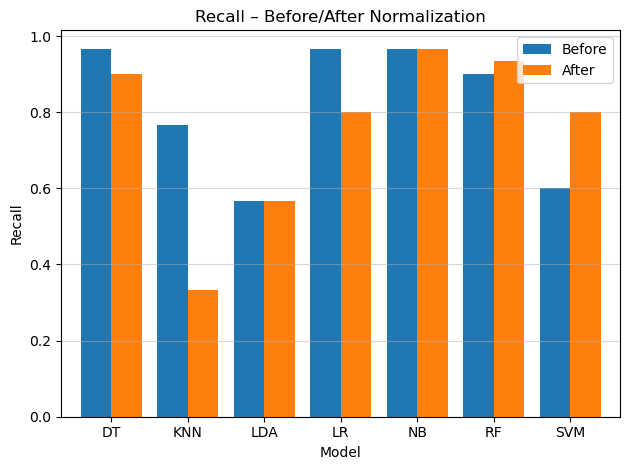

<Figure size 900x400 with 0 Axes>

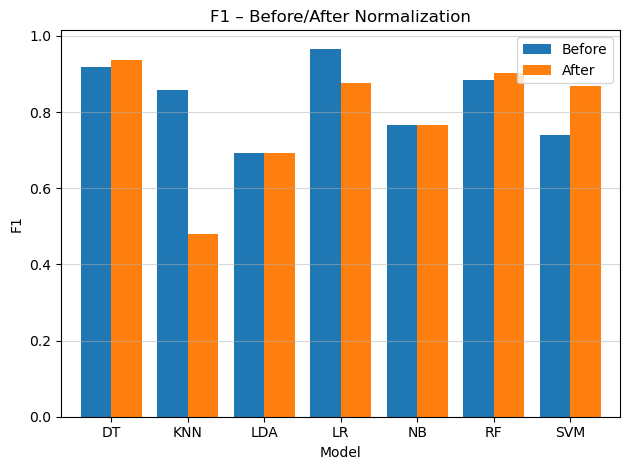

In [6]:
metrics = ["Accuracy","Precision","Recall","F1"]
for metric in metrics:
    comp_metric = comp.xs(metric, level="Metric", axis=1)
    plt.figure(figsize=(9,4))
    comp_metric.plot(kind="bar", width=0.8, title=f"{metric} – Before/After Normalization")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=.5)
    plt.tight_layout()
    plt.savefig(f"outputs_CV/{metric}_comparison.png")
    plt.show()

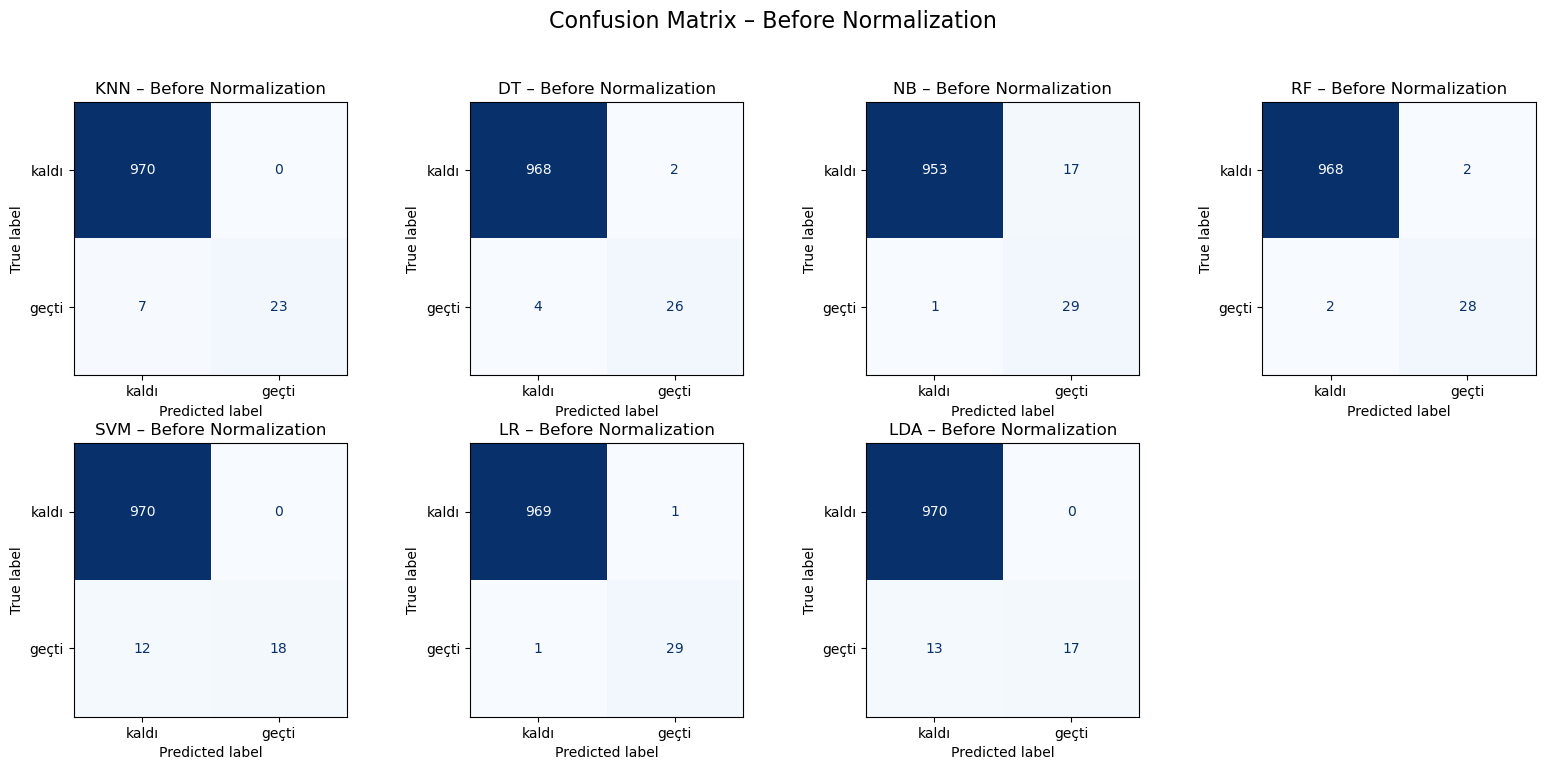

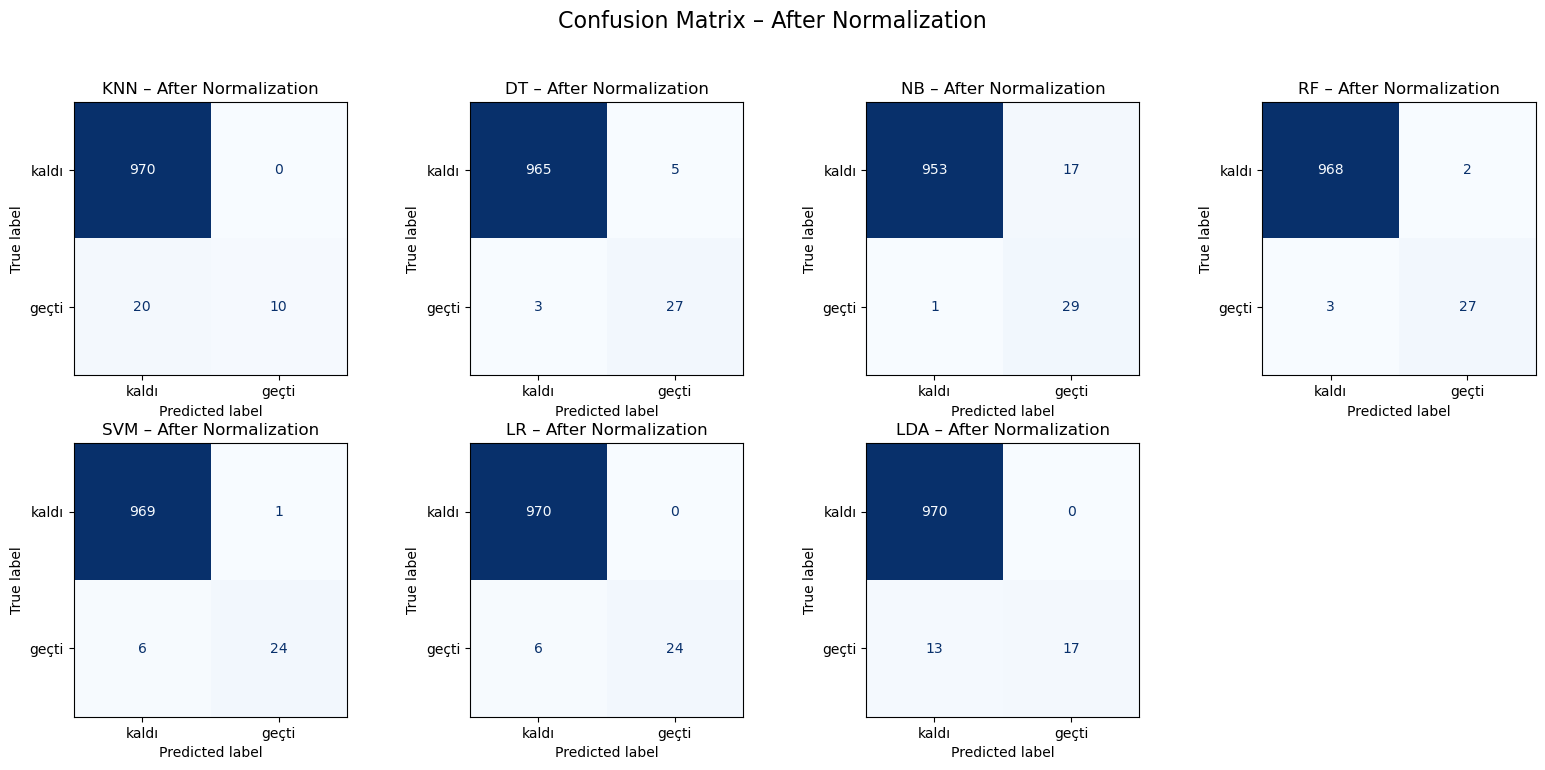

In [7]:
def plot_confusions(Xdata, tag):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()
    for i, (name, model) in enumerate(models.items()):
        y_pred = cross_val_predict(model, Xdata, y, cv=cv)
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["kaldı", "geçti"])
        disp.plot(ax=axs[i], cmap="Blues", values_format='d', colorbar=False)
        axs[i].set_title(f"{name} – {tag}")
    for j in range(len(models), len(axs)):
        fig.delaxes(axs[j])
    plt.suptitle(f"Confusion Matrix – {tag}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"outputs_CV/confusion_matrix_{tag.replace(' ', '_')}.png")
    plt.show()

plot_confusions(X, "Before Normalization")
plot_confusions(X_scaled, "After Normalization")

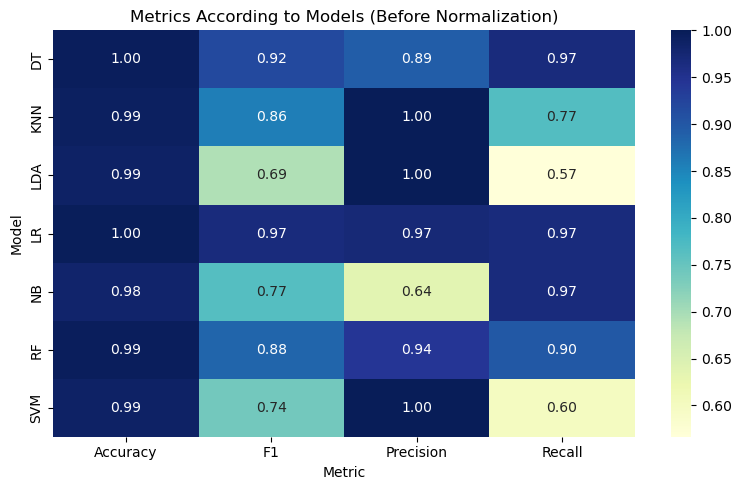

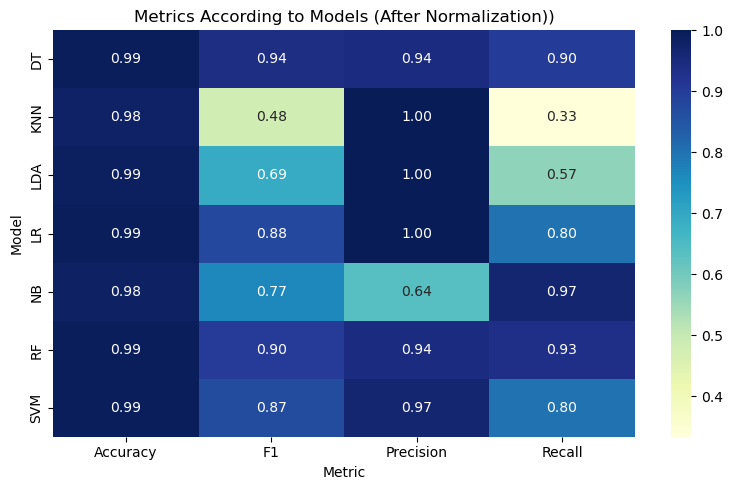

In [8]:
df_before = before_df.pivot(index="Model", columns="Metric", values="Before")
df_after  = after_df.pivot(index="Model", columns="Metric", values="After")

plt.figure(figsize=(8,5))
sns.heatmap(df_before, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Metrics According to Models (Before Normalization)")
plt.tight_layout()
plt.savefig("outputs_CV/metrics_before.png")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(df_after, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Metrics According to Models (After Normalization))")
plt.tight_layout()
plt.savefig("outputs_CV/metrics_after.png")
plt.show()

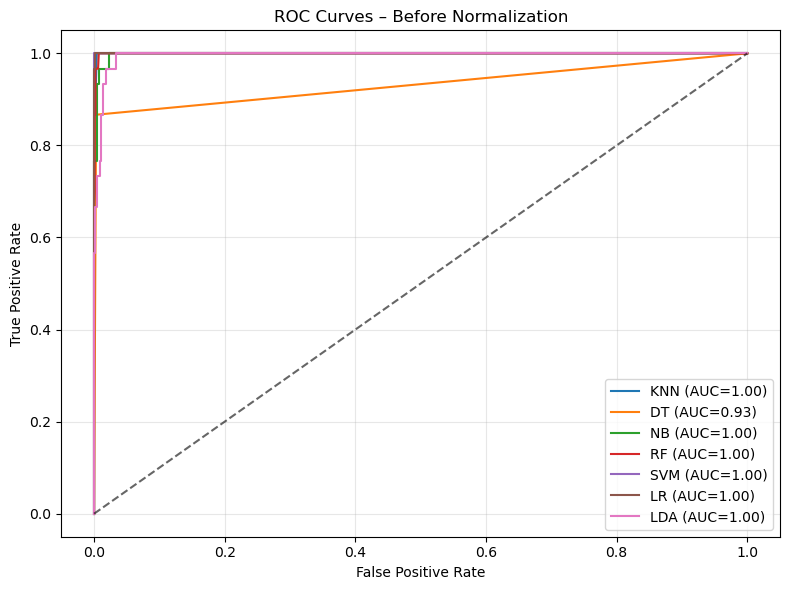

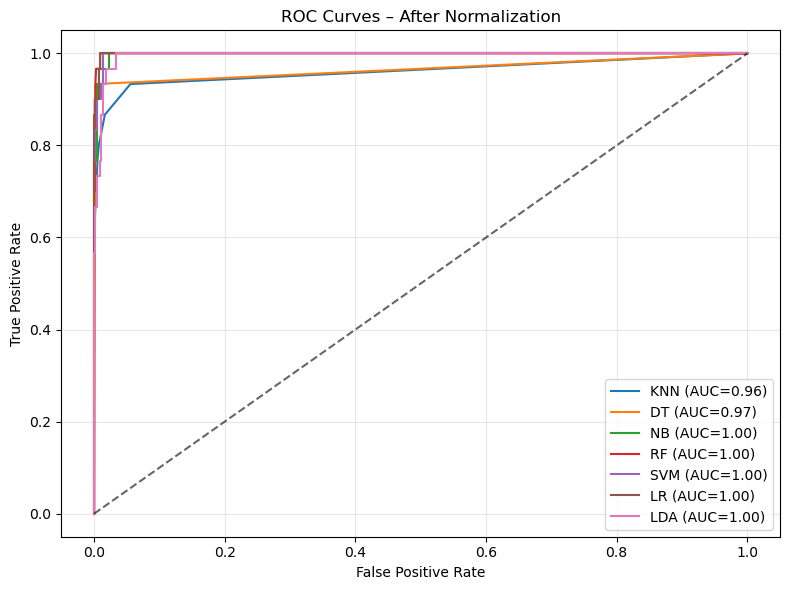

In [9]:
def plot_roc(Xdata, tag):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        y_score = cross_val_predict(model, Xdata, y, cv=cv, method="predict_proba")[:,1] \
                  if hasattr(model,"predict_proba") else \
                  cross_val_predict(model, Xdata, y, cv=cv, method="decision_function")
        fpr, tpr, _ = roc_curve(y, y_score)
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")
    plt.plot([0,1],[0,1],'k--',alpha=.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves – {tag}")
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.savefig(f"outputs_CV/roc_{tag.replace(' ', '_')}.png")
    plt.show()

plot_roc(X, "Before Normalization")
plot_roc(X_scaled, "After Normalization")